In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error
from  sklearn.feature_selection import VarianceThreshold
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read the random_forest data
data = pd.read_csv("/content/drive/MyDrive/results/word2vec.csv")


# select the features and targets
features = ['num_samples', 'num_features', 'dataset_size']
targets = ['Memory Usage','Total Time']


# assign the features and targets to X and y
X = data[features]
y = data[targets]

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
X_train.shape

(156, 3)

In [4]:
# create pipelines for all the models

# pipeline for linear regression model
LinearRegression_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(LinearRegression()))
])

# pipeline for lasso regression model
LassoRegression_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(Lasso()))
])

# pipeline for k nearest neighbors
kNNRegression_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(KNeighborsRegressor()))
])

# pipeline for random forest regressor
RandomForestRegressor_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(RandomForestRegressor()))
])


# pipeline for elastic net model
ElasticNet_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(ElasticNet()))
])

# pipeline for GradientBoostingRegressor model
GradientBoostingRegressor_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('variance', VarianceThreshold()),
    ('model', MultiOutputRegressor(GradientBoostingRegressor()))
])

Parameter Grid: We used a parameter grid to search for the best parameters for each of the models. We used the GridSearchCV function from sklearn.model_selection to search for the best parameters. We used the following parameters for each model:

*   Linear Regression:
  * fit_intercept, normalize, and copy_X.

*   Lasso Regression:
  * alpha, fit_intercept, normalize, and copy_X.

*   kNN Regression:
  * n_neighbors, weights, p.

*   Random Forest:
  * n_estimators, max_depth, max_features and criterion.

*   Elastic Net:
  *   alpha, l1_ratio and max_iter.

*   Gradient Boosting:
  *   n_estimators, learning_rate and max_depth


In [5]:
# list of parameter grid for all the models
param_grid = [
    {
        #random forest
        'model__estimator__n_estimators': [100, 200],
        'model__estimator__max_depth': [5, 10, 15],
        'model__estimator__max_features': ['auto', 'sqrt', 'log2', None],
        'model__estimator__criterion': ['absolute_error', 'squared_error'],
    },
    {
        #Linregression
        'model__estimator__fit_intercept': [True, False],
        'model__estimator__copy_X': [True, False],
    },
    {
        #Lassoregression
        'model__estimator__alpha': [0.1, 0.5, 1.0],
        'model__estimator__fit_intercept': [True, False],
        'model__estimator__copy_X': [True, False],
    },
    {
        #kNNregression
        'model__estimator__n_neighbors': [3, 5, 7],
        'model__estimator__weights': ['uniform', 'distance'],
        'model__estimator__p': [1, 2],
    },
    {
        #elastic
        'model__estimator__alpha': [0.1, 0.5, 1.0],
        'model__estimator__l1_ratio': [0.1, 0.5, 1.0],
        'model__estimator__max_iter': [100, 200, 300],
    },
    {
        #gradient
        'model__estimator__n_estimators': [100, 200, 300],
        'model__estimator__max_depth': [5, 10, 15],
        'model__estimator__learning_rate': [0.1, 0.05, 0.01],
    },

]

# create a dictionary of all the pipelines and their respective parameter grids
grid_dict = {   0: {'pipeline': RandomForestRegressor_pipeline, 'param_grid': param_grid[0]},
                1: {'pipeline': LinearRegression_pipeline, 'param_grid': param_grid[1]},
                2: {'pipeline': LassoRegression_pipeline, 'param_grid': param_grid[2]},
                3: {'pipeline': kNNRegression_pipeline, 'param_grid': param_grid[3]},
                4: {'pipeline': ElasticNet_pipeline, 'param_grid': param_grid[4]},
                5: {'pipeline': GradientBoostingRegressor_pipeline, 'param_grid': param_grid[5]}
            }

In [6]:
# Create a data_table df to store the results
data_table = pd.DataFrame(columns=['Regressor', 'Total Time_R2 Score', 'Total Time_MAE', 'Memory Usage_R2 Score', 'Memory Usage_MAE'])

# Grid search for all the pipelines
for i, (regressor, pipeline) in enumerate(grid_dict.items()):
    # create a grid search object
    grid = GridSearchCV(pipeline['pipeline'], param_grid=pipeline['param_grid'], cv=5, n_jobs=-1, verbose=1)
    # fit the grid search
    grid.fit(X_train, y_train)
    # do the predictions for the test set
    y_pred = grid.predict(X_test)

    # get the R2 score and mean absolute error for each target variable
    r2_score_total_time = r2_score(y_test['Total Time'], y_pred[:, 1])
    mae_total_time = mean_absolute_error(y_test['Total Time'], y_pred[:, 1])
    r2_score_memory_usage = r2_score(y_test['Memory Usage'], y_pred[:, 0])
    mae_memory_usage = mean_absolute_error(y_test['Memory Usage'], y_pred[:, 0])

    # add the results to the data_table dataframe
    data_table.loc[i] = [grid.best_estimator_.named_steps['model'].estimator.__class__.__name__, r2_score_total_time, mae_total_time, r2_score_memory_usage, mae_memory_usage]

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


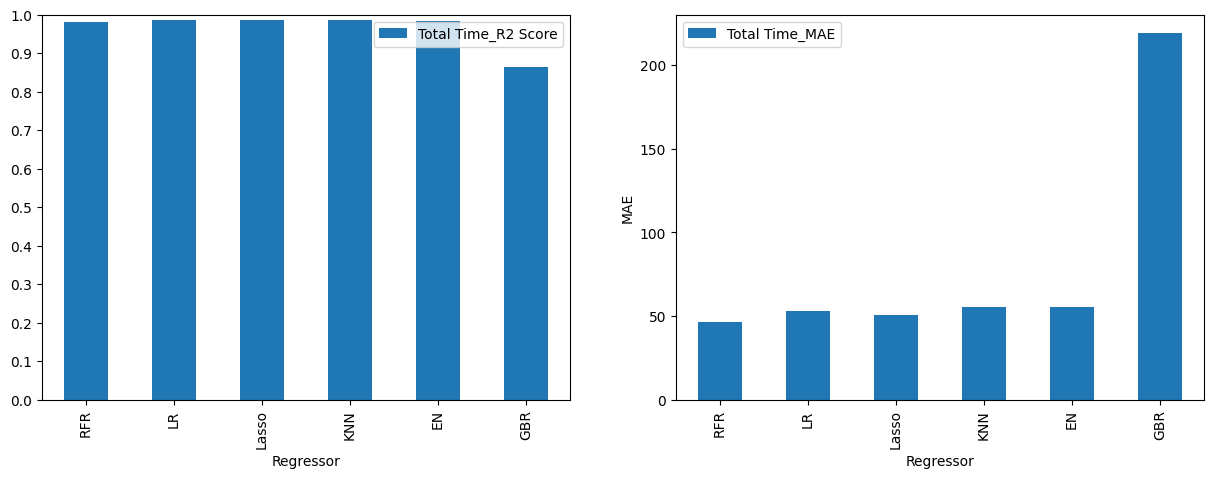

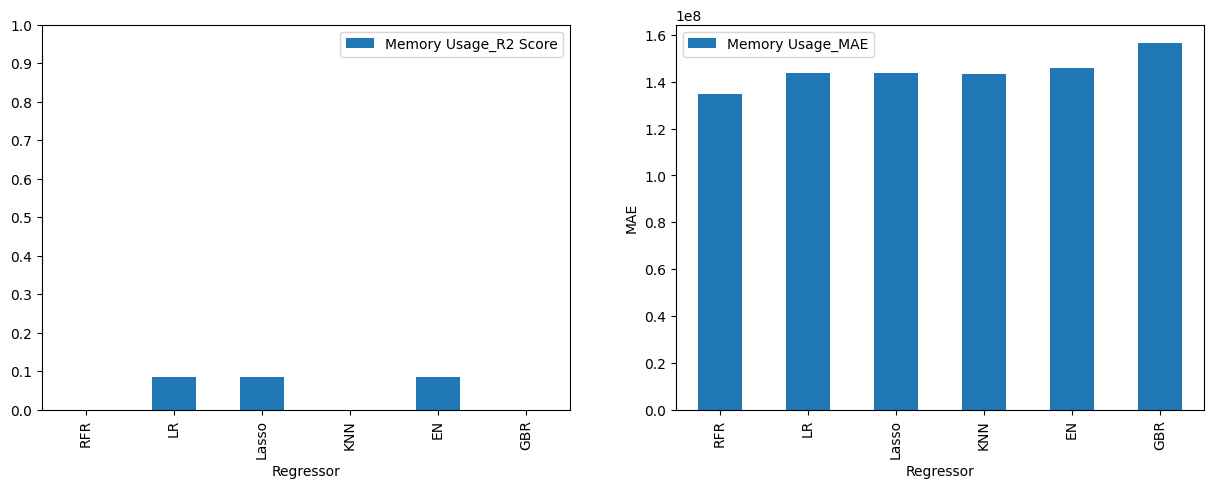

|    | Regressor   |   Total Time_R2 Score |   Total Time_MAE |   Memory Usage_R2 Score |   Memory Usage_MAE |
|---:|:------------|----------------------:|-----------------:|------------------------:|-------------------:|
|  0 | RFR         |              0.982066 |          46.3968 |              -0.0798763 |        1.3488e+08  |
|  1 | LR          |              0.984803 |          52.8772 |               0.085944  |        1.43602e+08 |
|  2 | Lasso       |              0.98494  |          50.8508 |               0.085944  |        1.43602e+08 |
|  3 | KNN         |              0.986983 |          55.1911 |              -0.0892095 |        1.43448e+08 |
|  4 | EN          |              0.984435 |          55.3091 |               0.0842975 |        1.45715e+08 |
|  5 | GBR         |              0.864949 |         219.17   |              -0.100364  |        1.56596e+08 |

In [8]:
from IPython.display import Markdown as md

name_map = {
    'RandomForestRegressor': 'RFR',
    'LinearRegression': 'LR',
    'LassoRegression': 'LAS',
    'KNeighborsRegressor': 'KNN',
    'GradientBoostingRegressor': 'GBR',
    'ElasticNet': 'EN',
}

# create a new column with the shorter names
data_table['Regressor'] = data_table['Regressor'].apply(lambda x: name_map.get(x, x))

# Display the results in a graph for Total Time R2 Score
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
data_table.plot(x='Regressor', y='Total Time_R2 Score', kind='bar', ax=ax[0])
plt.ylabel('R2 Score')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_ylim([0,1])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))

# Display the results in a graph for Total Time MAE
data_table.plot(x='Regressor', y='Total Time_MAE', kind='bar', ax=ax[1])
plt.ylabel('MAE')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.savefig('word2vec_total_time_results.pdf', bbox_inches='tight')
plt.show()
# Display the results in a graph for Memory Usage R2 Score
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
data_table.plot(x='Regressor', y='Memory Usage_R2 Score', kind='bar', ax=ax[0])
plt.ylabel('R2 Score')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[0].set_ylim([0,1])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))

# Display the results in a graph for Memory Usage MAE
data_table.plot(x='Regressor', y='Memory Usage_MAE', kind='bar', ax=ax[1])
plt.ylabel('MAE')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.savefig('word2vec_memory_results.pdf', bbox_inches='tight')
plt.show()



# display the results of the classifiers in a markdown table
markDownTableResults = data_table.to_markdown()
md(markDownTableResults)